# 08. Milestone Project 2: PyTorch Paper Replicating
The goal of machine learning research paper replicating is: turn a ML research paper into usable code.

In this notebook, we're going to be replicating the Vision Transformer (ViT) architecture/paper with PyTorch: https://arxiv.org/abs/2010.11929

See ground truth notebook here: https://www.learnpytorch.io/08_pytorch_paper_replicating/

## 0. Get setup
Let's import code we've previously written + required libraries.

In [1]:
import torch
import torchvision

print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")


torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torchinfo import summary
from going_modular.going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

## 1. Get data
The whole goal of what we're trying to do is to replicate the ViT architecture for our FoodVision Mini problem.

To do that, we need some data.

Namely, the pizza, steak and sushi images we've been using so far.

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi",
)
image_path


[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"


In [6]:
train_dir, test_dir


(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

In [7]:
from torchvision import transforms
from going_modular.going_modular import data_setup

# Create image size
IMG_SIZE = 224  # comes from Table 3 of the ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose(
    [transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()]
)

print(f"Manually created transforms: {manual_transforms}")


Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [8]:
# Create a batch size of 32 (the paper uses 4096 but this may be too big for our smaller hardware... can always scale up later)
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir, test_dir=test_dir, transform=manual_transforms, batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names


(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single a image
As always, let's adhere to the motto, visualize, visualize, visualize!

In [9]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the single image and label shapes
image.shape, label


(torch.Size([3, 224, 224]), tensor(2))

(-0.5, 223.5, 223.5, -0.5)

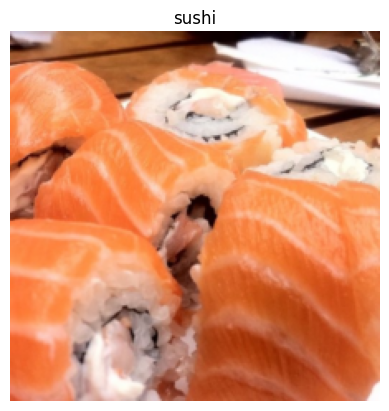

In [10]:
# Plot the image with matplotlib
import matplotlib.pyplot as plt

plt.imshow(
    image.permute(1, 2, 0)
)  # (color_channels, height, width) -> (height, width, color_channels)
plt.title(class_names[label])
plt.axis(False)
